In [9]:
#brew install freetype pkg-config gcc openssl hdf5 ta-lib
#export HDF5_DIR=/opt/homebrew/opt/hdf5               
#export BLOSC_DIR=/opt/homebrew/opt/c-blosc
#pip3 install git+https://github.com/PyTables/PyTables

# API Key NtmGKaXUvXvdg7asekzN


In [10]:
# https://zipline.ml4trading.io/index.html
import numpy as np 
import statsmodels as sm 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import zipline
import seaborn as sns
import matplotlib.pyplot as plt
import predictor 
import optimizer
import os
plt.rcParams["figure.figsize"] = (20,3)
os.environ['ZIPLINE_ROOT']='./'


In [11]:
%load_ext zipline


The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline


In [22]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
df = df[df["Date added"]<="2012"]
df.to_csv("symbol_info.csv")
symbols = [x for x in df['Symbol'] if x not in ['BRK.B','BF.B']]
print(len(symbols))


303


In [29]:
from zipline.api import order_target, record, symbol, order_target_percent
import matplotlib.pyplot as plt

def initialize(context):
    context.i = 0
    context.assets = [symbol(x) for x in symbols]
    #print(context.assets)


def handle_data(context, data):
    # Skip first 50 days to get full windows
    context.i+=1
    if context.i < 50:
        return
    # Get rolling window of past prices and compute returns
    prices = data.history(context.assets, 'price', bar_count=50, frequency="1d")
    returns = prices.pct_change().dropna()
    try:
        weights = optimizer.rand_weights(returns)
        
        for stock, weight in zip(prices.columns, weights):
            order_target_percent(stock, weight)
            
        record(**{i.symbol:k for i,k in zip(prices.columns, weights)})
    except ValueError as e:
        print(e)
        pass


In [30]:
from zipline import run_algorithm
import pandas as pd
import pandas_datareader.data as web
start = pd.Timestamp('2020-11-01')
end = pd.Timestamp('2022-11-01')

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.pct_change()

result = run_algorithm(start=start,
                       end=end,
                       initialize=initialize,
                       handle_data=handle_data,
                       capital_base=1000000,
                       benchmark_returns=benchmark_returns,
                       bundle='SP-Datathon',
                       data_frequency='daily')


True   data/SP-Datathon/2023-10-09T19;44;45.738995/assets-7.sqlite
True   data/SP-Datathon/2023-10-09T19;44;45.738995/adjustments.sqlite
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback object at 0x314f47040>)
(<class 'TypeError'>, TypeError("'DataFrame' object cannot be interpreted as an integer"), <traceback objec

TypeError: 'DataFrame' object cannot be interpreted as an integer

<Axes: >

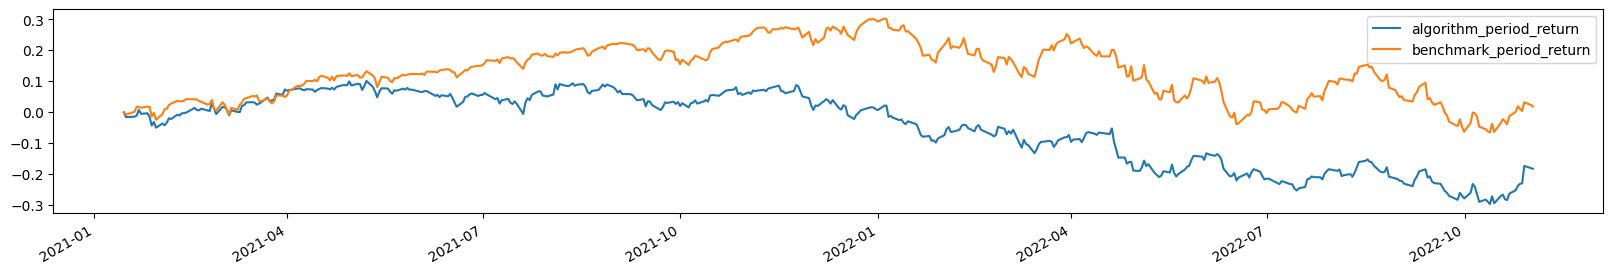

In [27]:
result['benchmark_period_return']-=result['benchmark_period_return'].values[50]
result[['algorithm_period_return','benchmark_period_return']].iloc[50:].plot()


<Axes: >

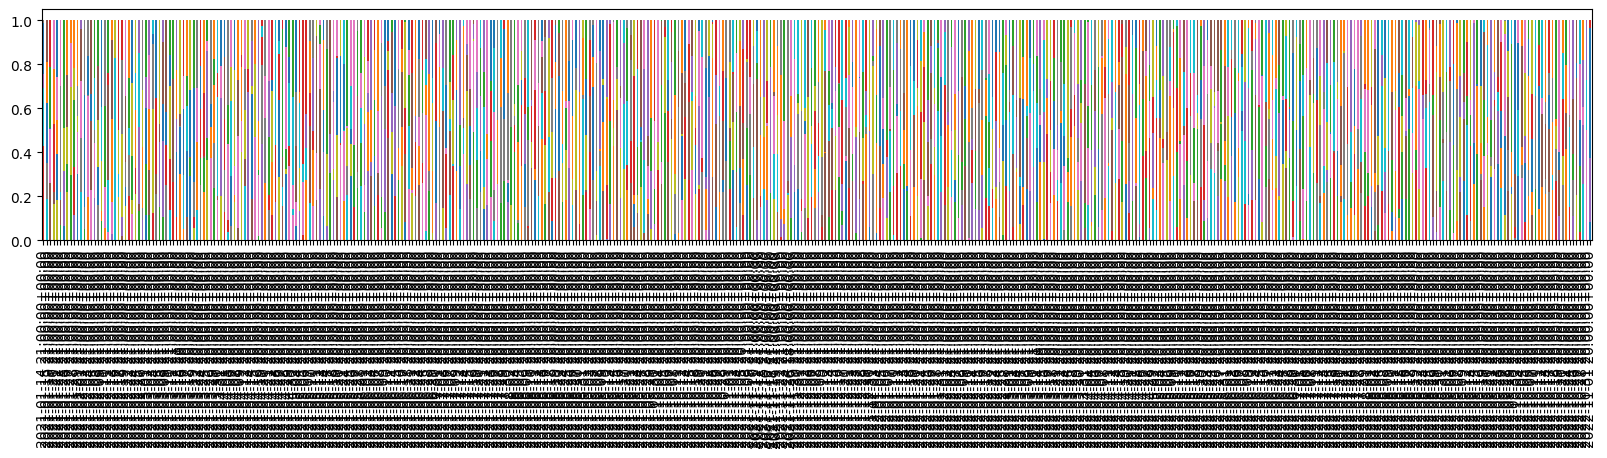

In [28]:
result[result.columns[-len(symbols):]].iloc[50:].plot.bar(stacked=True,legend=False)
